# **Demonstrate the use cases and features of the `neivapy` python package**












## **1. Setting up the NEIVA database in the colab environment.**

In [ ]:
!pip install mysql-connector-python # Install the necessary package to connect Python with MySQL databases.
!pip install pubchempy
!apt-get update
!pip install pymysql
!apt-get -y install mysql-server    # Install the MySQL server on the Colab environment.
!service mysql start                # With MySQL install, this starts the server.

# Setting the password. Here 'root' is used as password.

!mysql -e "ALTER USER 'root'@'localhost' IDENTIFIED WITH 'mysql_native_password' BY 'root';FLUSH PRIVILEGES;"

In [2]:
# Remove the existing NEIVA repository if it exists.
!rm -rf NEIVA
# Download the NEIVA repository from GitHub
!git clone https://github.com/NEIVA-BB-emissions-Inventory/NEIVA.git

Cloning into 'NEIVA'...
remote: Enumerating objects: 1180, done.
remote: Counting objects: 100% (211/211), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 1180 (delta 146), reused 126 (delta 70), pack-reused 969
Receiving objects: 100% (1180/1180), 3.91 MiB | 1.82 MiB/s, done.
Resolving deltas: 100% (876/876), done.


In [3]:
# Check if the repository is downloaded by listing its contents.
!ls NEIVA/data

backend_db.sql	csv  legacy_db.sql  neiva_output_db.sql  primary_db.sql  raw_db.sql


In [ ]:
# Initialize MySQL databases and import data from NEIVA SQL files
!mysql -u root -proot -e "CREATE DATABASE IF NOT EXISTS backend_db"
!mysql -u root -proot backend_db < NEIVA/data/backend_db.sql
!mysql -u root -proot -e "CREATE DATABASE IF NOT EXISTS legacy_db"
!mysql -u root -proot legacy_db < NEIVA/data/legacy_db.sql
!mysql -u root -proot -e "CREATE DATABASE IF NOT EXISTS neiva_output_db"
!mysql -u root -proot neiva_output_db < NEIVA/data/neiva_output_db.sql
!mysql -u root -proot -e "CREATE DATABASE IF NOT EXISTS primary_db"
!mysql -u root -proot primary_db < NEIVA/data/primary_db.sql
!mysql -u root -proot -e "CREATE DATABASE IF NOT EXISTS raw_db"
!mysql -u root -proot raw_db < NEIVA/data/raw_db.sql


---
## An overview of the database content is given below-
*   `legacy_db (ldb)`: The Akagi et al supplement, inlcuding 2014 and 2015 updates, are stored as tabled in this repository.
*   `raw_db (rdb)`: Data from selected publciations are stores as tables in the repository.
*   `primary_db (pdb)`: Data from legacy and raw db were reformatted to achieve a consistent structure and stored in this db.
*   `neiva_output_db` (`output_db`): The output of the data integartion and processing algorithmn is stored in this db. It contains 4 tables:
`Integrated_EF` (`integrated ef`): The output of the data integration step is stored in this table.
`Processed_EF` (`processed ef`): The Integreated_EF table undergoes several data processing steps, the output is stored in Processed_EF table.
`Recommended_EF` (`processed ef`): The calculated averages of all EFs for each of the fire types are stored in this table.
`Property_Surrogate`: Chemical and physical property data, as well as surroagte model species assignments for each of the NMOC_g (Non methane organic compound gaseous) is stored in this table.
*   `backend_db` (`bk_db`): Tables that are used in the python scripts for processing data and generating tables are stored in this database.
---

In [5]:
!mysql -u root -proot -e "show databases;"

mysql: [Warning] Using a password on the command line interface can be insecure.
+--------------------+
| Database           |
+--------------------+
| backend_db         |
| information_schema |
| legacy_db          |
| mysql              |
| neiva_output_db    |
| performance_schema |
| primary_db         |
| raw_db             |
| sys                |
+--------------------+


In [6]:
!mysql -u root -proot -e "use neiva_output_db; show tables;"

mysql: [Warning] Using a password on the command line interface can be insecure.
+---------------------------+
| Tables_in_neiva_output_db |
+---------------------------+
| Integrated_EF             |
| Processed_EF              |
| Property_Surrogate        |
| Recommended_EF            |
+---------------------------+


## **2. Import the `neivapy` package and other essential python libraries**

In [7]:
import NEIVA.neivapy as nv

In [8]:
from sqlalchemy import text
import pandas as pd
import warnings
warnings.simplefilter("ignore", UserWarning)
from google.colab import files

## **3 Demonstrate query functions**

##**3.1 Display information**

`nv.fire_type()` Returns the list of the fire types.

In [9]:
nv.fire_type()

['boreal forest',
 'chaparral',
 'cookstove',
 'crop residue',
 'dung burning',
 'garbage burning',
 'open cooking',
 'peat',
 'savanna',
 'temperate forest',
 'tropical forest',
 'charcoal burning',
 'charcoal making',
 'pasture maintenance']

`nv.table_info(database, fire type)`Returns a list of table names along with
associated information.
*   Options for database: `ldb` (legacy db), `rdb` (raw db), `pdb` (primary db)
*   Options for fire type: Can be obtained from `nv.fire_type()` function.

In [10]:
dd=nv.table_info ('rdb','garbage burning')
dd

,tbl_name,measurement_type,fire_type,pollutant_category,study,source,doi
6,rdb_gb_yokelson13,lab,garbage burning,"methane,NMOC_g,inorganic gas,PM total",yokelson13,Table S1,doi.org/10.5194/acp-13-89-2013
7,rdb_goetz18,field,dung burning;cookstove;crop residue;garbage bu...,"PM total,PM carbon,PM ion",goetz18,Supplement section 3 and 4,doi.org/10.5194/acp-18-14653-2018
11,rdb_jayarathne18,field,coal burning;garbage burning;cookstove;dung bu...,"PM total,PM carbon,PM ion,PM metal,NMOC_p:poly...",jayarathne18,"Table 2, 3.2 Emission of OC, EC and WSOC",doi.org/10.5194/acp-18-2585-2018
21,rdb_stockwell15,lab,crop residue;boreal forest;chaparral;cookstove...,"inorganic gas,methane,NMOC_g",stockwell15,Table S2,doi.org/10.5194/acp-15-845-2015
22,rdb_stockwell16,lab;field,coal burning;dung burning;cookstove;open cooki...,"methane,inorganic gas,NMOC_g,PM carbon,PM opti...",stockwell16,"Table S8, Table S7, Table S9, Table 6",doi.org/10.5194/acp-16-11043-2016


In [13]:
# download data
dd.to_csv('dd.csv')
files.download('dd.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`nv.summary_table(fire type, measurement type)` Returns a list of emission factor (EF) column names of the integrated EF table along with information- MCE, fuel type, cookstove name if available.
*   Options for fire type: Can be obtained from `nv.fire_type()` function.
*   Options for measurement type: `lab`, `field`, `all`

In [14]:
nv.summary_table('cookstove', 'field')

,efcol,measurement_type,MCE,fuel_type,cookstove_name,cookstove_type,study
0,EF_akagi11_patsari_cookstove_christian10,field,0.970,mixed fuel,patsari,improved,Akagi_11(christian10)
1,EF_akagi11_patsari_cookstove_johnson08,field,0.950,mixed fuel,patsari,improved,Akagi_11(johnson08)
2,EF_hw_1_pot_traditional_mudstove_stockwell16,field,0.933,hardwood,mudstove,traditional,stockwell16
3,EF_biogas_stove_stockwell16,field,0.999,biogas,biogas stove,improved,stockwell16
4,EF_hw_1_pot_traditional_mudstove_1_stockwell16,field,0.914,hardwood,mudstove,traditional,stockwell16
5,EF_wood_gyapa_coffey17,field,0.945,hardwood,gayapa,improved,coffey17
6,EF_wood_philip_coffey17,field,0.958,hardwood,philip,improved,coffey17
7,EF_brushwood_chulha_fleming18,field,0.937,brushwood,chulha,improved,fleming18
8,EF_mixed_fuel_chulha_fleming18,field,0.892,mixed fuel,chulha,improved,fleming18
9,EF_1_pot_traditional_mudstove_hardwood_goetz18,field,0.914,hardwood,mudstove,traditional,goetz18


`nv.display_pollutant_category()` Displays the list of pollutant category.

In [15]:
nv.display_pollutant_category()

['inorganic gas',
 'methane',
 'NMOC_g',
 'PM size',
 'PM organic',
 'PM elemental',
 'PM ion',
 'PM metal',
 'NMOC_p',
 'PM optical property']

`nv.property_varaibles()` Displays the property variables, chemcial mechanism, description, unit, sources of the Property_Surrogate table.

In [16]:
nv.property_variables()

,column name,description,unit
0,mm,Molecular mass,g/mole
1,formula,Molecular formula,nan
2,compound,Compound name obtained from the source publica...,nan
3,smile,Simplified molecular input lin entry system,nan
4,S07,SAPRC-07 chemical mechanism model species,nan
5,S07T,SAPRC-07 (Toxic version) chemical mechanism mo...,nan
6,S18B,SAPRC-18 chemical mechanism model species,nan
7,S22,SAPRC-22 chemical mechanism model species,nan
8,MOZT1,MOZART T1 version chemical mechanism,nan
9,GEOS_chem,GEOS-Chem chemical mechanism,nan


`nv.model_surrogate()` Displays the unique set of model surrogates for a specified chemical mechanism.
*   Options for chemical mechanism: `S07`, `S07T`, `S18B`, `MOZT1`, `GEOS_chem`

*Note:* The description of the chemcial mechanism variables can be obtained from `nv.property_variables()`.

In [18]:
nv.model_surrogates('MOZT1')

array(['C2H2', 'NROG', 'C2H4', 'C2H6', 'CH2O', 'CH3OH', 'BIGENE', 'C3H6',
       'CH3CHO', 'C3H8', 'C2H5OH', 'HCOOH', 'GLYOXAL', 'BIGALK',
       'CH3COCH3', 'CH3COOH', 'GLYALD', 'TOLUENE', 'ISOP', 'MVK', 'MACR',
       'CH3COCHO', 'MEK', 'HYAC', 'BENZENE', 'XYLENES', 'MBO', 'PHENOL',
       'ALKNIT', 'BZALD', 'CRESOL', 'MTERP', 'MYRC', 'APIN', 'BPIN',
       'LIMON', 'TERPROD1', 'BCARY'], dtype=object)

## **3.2 Query emission factor (EF)**





`nv.select_compound(fire type, compound, table_or_db)` Returns the EF data.
*   Options for fire type: Can be optained from `nv.fire_type()`
*   Options for compound: `compound name (e.g., phenol, methanol)` which includes inorganic gas, methane, NMOC_g, NMOC_p and `PM2.5*`,`PM2.5`, `PM10`,`PM1`,`PM2.5(PM1-PM5)`, `OC`, `BC`, `EC`, `OA`, `NOx_as_NO`.
*   Options for table_or_db: `integrated ef`, `processed ef`, `recommended ef`, `ldb` (legacy db), `rdb` (raw db).

In [20]:
dd=nv.select_compound ('savanna', 'PM2.5', 'processed ef')
dd[['legend','EF']]

,legend,EF
0,Akagi_11(Sinha et al 03),10
1,Akagi_11(Yokelson et al 11),7.65
2,Akagi_11(Ferek et al 98),3.86
3,Jayarathne et al 14,2.3


`nv.select_chemical_formula(fire_type, chemical_formula, table name)` Returns the EF data.
*   Options for chemcial formula: `chemical formula of compounds` (e.g., CO, CO2, C10H16).
*   Options for table name: `integrated ef`, `processed ef`, `recommended ef`.



In [21]:
nv.select_chemical_formula ('savanna', 'CHNO', 'integrated ef')

,mm,formula,compound,EF_akagi11_africa_stockwell15,EF_akagi11_africa_christian03,EF_akagi11_africa_yokelson03,EF_akagi11_africa_sinha03,EF_akagi11_brazil_ferek98,EF_akagi11_mexico_early_dry_season_yokelson11,EF_akagi11_imperata_cylindrica_christian03,EF_african_grass_jayarathne14,EF_peat_african_grass_short_pokhrel16,EF_african_grass_tall_pokhrel16,EF_savanna_desservettaz20,EF_grassland_travis23
0,43,CHNO,Isocyanic acid,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.05


`nv.select_pm_data(fire type, table name)` Returns EF of PM2.5*, PM10, OA, OC, BC, EC.
*   Options for table name: `integrated ef`, `processed ef`, `recommended ef`.

In [25]:
nv.select_pm_data ('crop residue', 'processed ef')

,legend,MCE,PM2.5,PM1,PM10,PM2.5(non-pile burning),PM2.5(pile-burning),OC,BC,OA,EC
0,Travis et al 23,0.93,nan,18.8,nan,nan,nan,8.25,0.13,16.02,nan
1,Travis et al 23,0.91,nan,30.66,nan,nan,nan,15.29,0.09,28.11,nan
2,Travis et al 23,0.91,nan,19.38,nan,nan,nan,9.24,0.12,17.83,nan
3,Travis et al 23,0.96,nan,16.26,nan,nan,nan,7.18,nan,15.12,nan
4,Lasko et al 18,nan,nan,nan,nan,8.8,16.9,nan,nan,nan,nan
5,Goetz et al 18,0.96,nan,3.44,nan,nan,nan,nan,0.41,2.64,nan
6,Goetz et al 18,0.95,nan,4.55,nan,nan,nan,nan,0.64,3.34,nan
7,Goetz et al 18,0.92,nan,4.18,nan,nan,nan,nan,0.6,3.22,nan
8,Goetz et al 18,0.96,nan,2.69,nan,nan,nan,nan,0.28,1.82,nan
9,Jayarathne et al 18,0.93,11.48,nan,nan,nan,nan,6.31,nan,nan,0.98


`nv.select_ef_pollutant_category(fire type, pollutant category)` Returns EF data.
*   Options for pollutant category: Can be obtained from `nv.display_pollutant_category()`.

In [26]:
nv.select_ef_pollutant_category('crop residue', 'PM optical property')

,compound,AVG_crop_residue
0,EF B abs 870 (m2 kg 1),2.05
1,EF B scat 870 (m 2 kg 1),18.22
2,EF Babs 405 (m2 kg1),19.17
3,EF Babs 405 just BC (m2 kg1),8.47
4,SSA 870 nm,0.89
5,SSA 405 nm,0.81
6,AAE,3.31
7,SSA 532,0.89
8,SSA 660,0.91
9,BrC,10.93


`nv.compare_lab_field(fire type, compound, table name)` Returns the mean EF, mean MCE, number of data count of laboratory versus field data.
*   Options for compound: `compound name (e.g., phenol, methanol)` which includes inorganic gas, methane, NMOC_g, NMOC_p and `PM2.5*`, `PM10`, `OC`, `BC`, `EC`, `OA`, `NOx_as_NO`.
*   Options for table name: `integrated ef`, `processed ef`

In [27]:
nv.compare_lab_field ('temperate forest', 'methanol','processed ef')

,Mean,Lab,Field
0,Methanol EF,1.82,1.83
1,MCE,0.91,0.91
2,data count,3,12


`nv.ef_sorted_by_property(df, fire type, chem, model surrogate, property variable)` Returns the EF of NMOC_g sorted by the specified property varaible in ascending order. The NMOC_g is selected for a specifed fire type, chemical mechanism and model surrogate. This function also requires a dataframe as input.
*   Options for fire type: Can be obtained from `nv.fire_type()`.
*   Options for chemical mechasnim, property varaible can be obtained from `nv.property_varaibles()`.
*   Options for model surrogate can be obtained from `nv.model_surrogate()`.

In [28]:
output_db=nv.connect_db('neiva_output_db')
rdf=pd.read_sql(text('select * from Recommended_EF'), con=output_db)
nv.ef_sorted_by_property (rdf, 'temperate forest', 'S22', 'XYNL', 'hc')

,mm,formula,compound,AVG_temperate_forest,N_temperate_forest,STD_temperate_forest,S22,hc
0,122,C7H6O2,2-hydroxybenzaldehyde (=salicylaldehyde),0.07,4,0.04,XYNL,6e-06
1,138,C8H10O2,2-methoxy-4-methylphenol (= creosol),0.3,7,0.19,XYNL,1e-06
2,124,C7H8O2,Guaiacol (=2-methoxyphenol),0.48,8,0.31,XYNL,1e-06
3,122,C8H10O,"2,5-dimethyl phenol",0.09,2,0.07,XYNL,1e-06
4,154,C8H10O3,Syringol,0.08,7,0.07,XYNL,2e-07
5,110,C6H6O2,Resorcinol,1.49,3,0.83,XYNL,1e-10
6,150,C9H10O2,Vinyl guaiacol,0.15,3,0.1,XYNL,nan


`nv.plot_ef(fire type, compound, table name)` Generates a scatter plot illustrating study(fuel type) versus EF the specified options.
*   Options for fire type: Can be obtained from `nv.fire_type()`.
*   Options for compound: `compound name (e.g., phenol, methanol)` which includes inorganic gas, methane, NMOC_g, NMOC_p and `PM2.5*`, `PM10`, `OC`, `BC`, `EC`, `OA`, `NOx_as_NO`.
*   Options for table name: `integrated ef`, `processed ef`



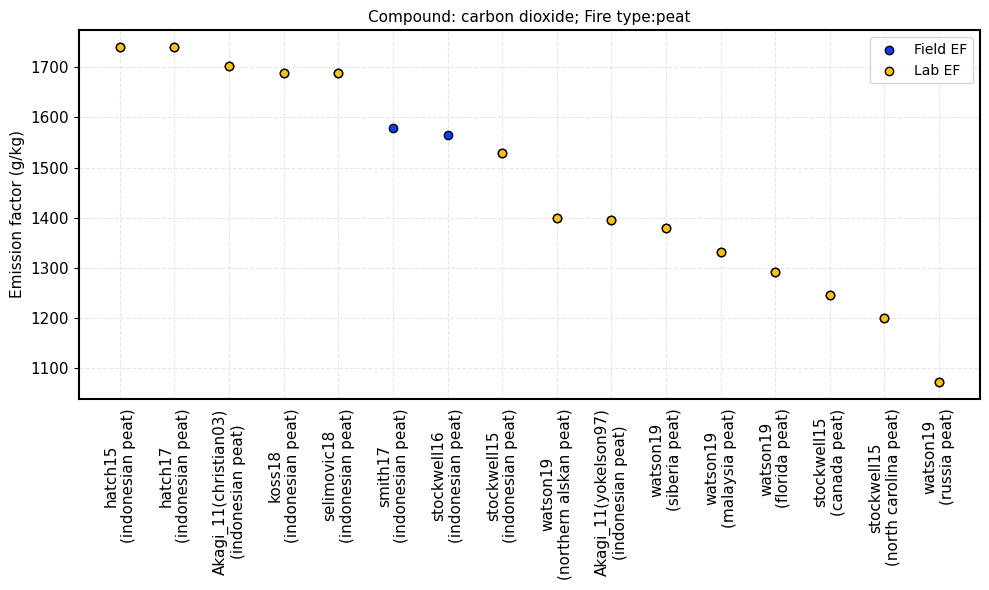

In [32]:
nv.plot_ef('peat', 'carbon dioxide', 'integrated ef')

`nv.boxplot_ef(compound, fire type, table name)` This function id identical to `nv.plot_ef()` but it generates a boxplot of the EF data instead of a scatter plot.
*   Options for fire type: Can be obtained from nv.fire_type(). Additionally, the `all` option includes tropical forest, temperate forest, boreal forest, savanna, crop residue, peat)
*   Option for table name: `integrated ef`, `processed ef`



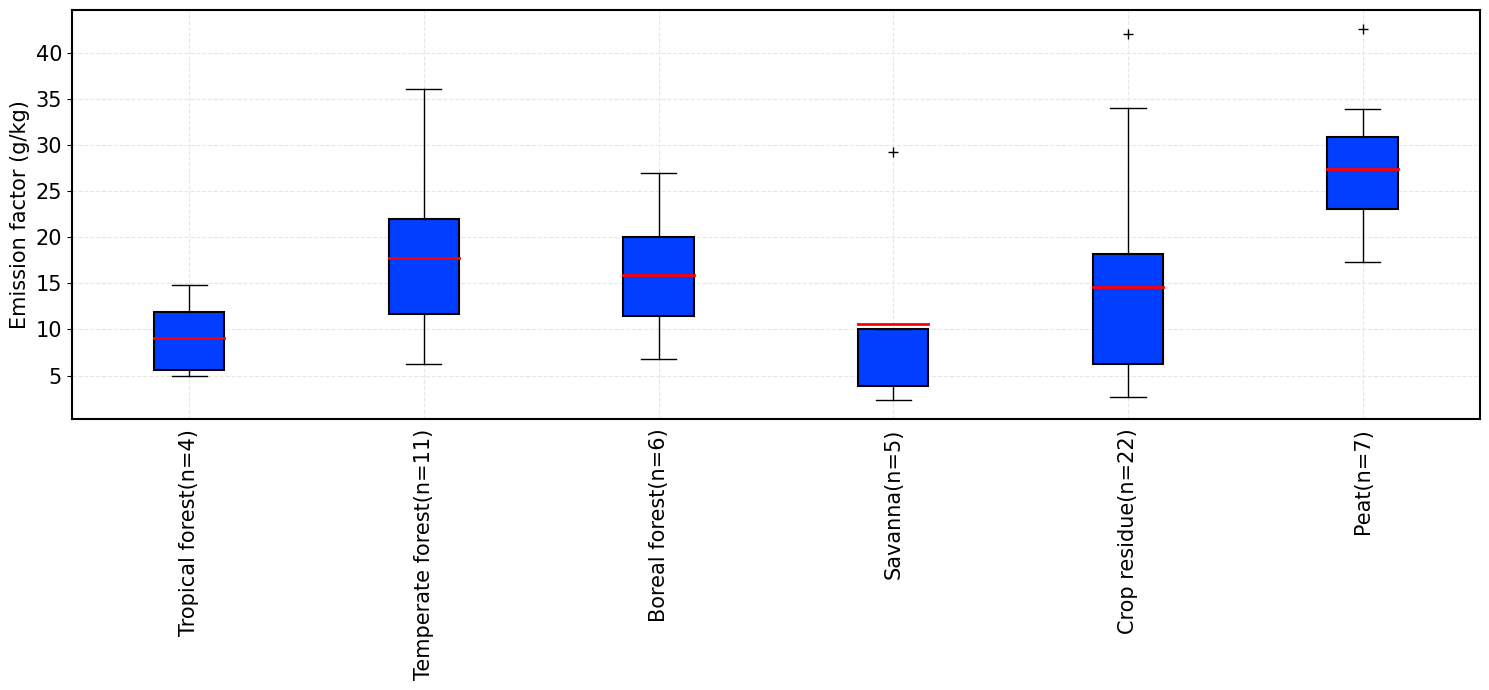

In [34]:
nv.boxplot_ef ('PM2.5*', 'all', 'integrated ef')

`nv.mce_vs_ef(compound, fire_type)` This fucntion generates a scatter plot of the MCE versus EF data and produces a linear fit if the data count is greater than 4.
*   Options for compound: `compound name (e.g., phenol, methanol)` which includes inorganic gas, methane, NMOC_g, NMOC_p and `PM2.5*`, `PM10`, `OC`, `BC`, `EC`, `OA`, `NOx_as_NO`.
*   Options for fire type: Can be obtained from `nv.fire_type()` and `all`.

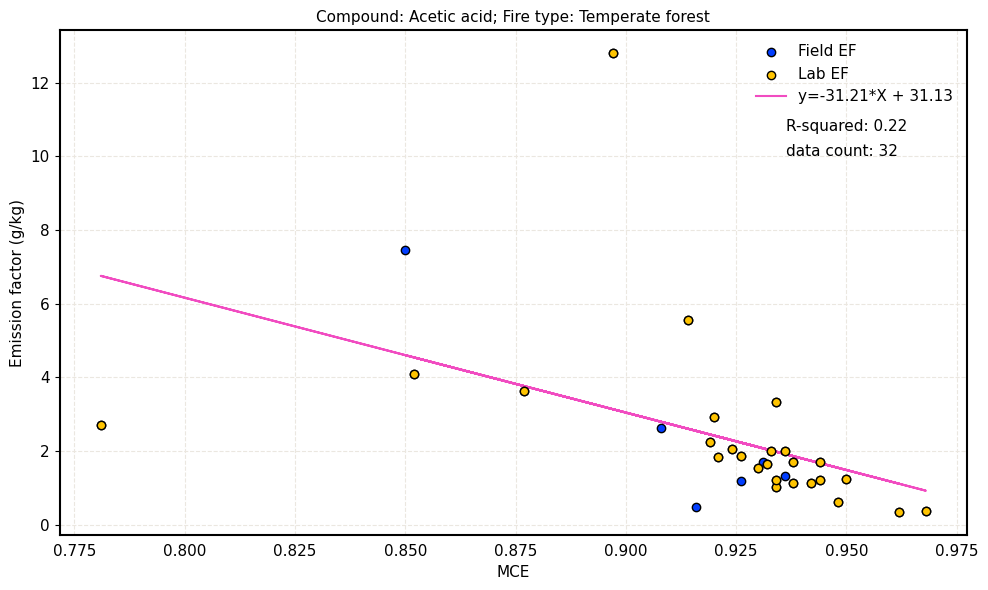

In [37]:
nv.mce_vs_ef ('acetic acid', 'temperate forest')

## **3.3 Query NMOC_g emission profile**

`nv.voc_profile(df, chem, fire type)` Returns the mole fraction of the model surrogates. It requires a dataframe in recommended EF table format as input.
*   Options for chem (chemical mechanism): Can be obtained from `nv.property_variables()`.
*   Options for fire type: Can be obtained from `nv.fire_type()`.

In [38]:
output_db=nv.connect_db('neiva_output_db')
rdf=pd.read_sql(text('select * from Recommended_EF'), con=output_db)

`nv.calc_OHR(df, chem, fire type, sum_nmoc_g_ef_in_ppb)` Calculates the OH reactivity (OHR) of model surrogates. It requires a dataframe in recommended EF table format as input.
*   Options for chem(chemcial mechanism): Can be obtained from `nv.property_variables()`.
*   Options for fire type: Can be obtained from `nv.fire_type()`.
*   `sum_nmoc_g_ef_in_ppb`: The summation of NMOC_g EF in ppb unit.

In [39]:
nv.calc_OHR(rdf,'S07','temperate forest',91)

,S07,OHR,OHR_frac
0,CRES,13.06,0.21
1,OLE2,13.02,0.21
2,MVK,7.52,0.12
3,ARO2,4.31,0.07
4,TERP,3.38,0.05
5,OLE1,3.13,0.05
6,IPRD,2.6,0.04
7,ARO1,2.29,0.04
8,CCHO,2.05,0.03
9,HCHO,1.85,0.03


`nv.calc_VBS(df, fire type)` Calculates the volatility basis set. It requires a dataframe in recommended EF table format as input.
*   Options for fire type: Can be obtained from `nv.fire_type()`.

In [40]:
nv.calc_VBS(rdf,'temperate forest')

,bin,ef/sum_ef
0,"(0, 1]",nan
1,"(1, 2]",0
2,"(2, 3]",0
3,"(3, 4]",7e-03
4,"(4, 5]",2e-03
5,"(5, 6]",0.07
6,"(6, 7]",0.03
7,"(7, 8]",0.13
8,"(8, 9]",0.2
9,"(9, 10]",0.25


`nv.weighted_property(df, fire type, chem)` Calculates property variables weighted by the EF of individual compounds for each model surroagte. It requires a dataframe in the recommended EF table format as input.
*   Options for fire type: Can be obtained from `nv.fire_type()`.
*   Options for chem(chemcial mechanism): Can be obtained from `nv.property_variables()`.

In [42]:
nv.weighted_property(rdf, 'peat', 'S07')

,S07,EF(g/kg),mole,mm,kOH(cm3/molecule sec),cstar,vp(mm hg),hc(atm m3/mole),mole_fraction
0,NROG,8.05,0.24,43.01,7e-14,10.94,1459.6,0.06,0.17
1,MEOH,3.7,0.12,31,9e-13,8.88,127,5e-06,0.09
2,OLE2,7.98,0.1,86.72,7e-11,8.49,533.76,0.06,0.07
3,ALK2,4.6,0.1,47.71,1e-12,10.0,6364.61,0.63,0.07
4,AACD,5.51,0.09,60.000000000000,7e-13,7.64,15.7,1e-07,0.07
5,ALK1,2.53,0.08,30,2e-13,10.61,3e+04,0.5,0.06
6,OLE1,4.58,0.08,78.02,3e-11,9.02,3971.69,0.24,0.06
7,CCHO,3.35,0.07,51.3,1e-11,8.57,490.77,4e-05,0.05
8,ETHE,1.54,0.05,28,8e-12,10.33,5e+04,0.23,0.04
9,ALK5,4.13,0.05,95.86,5e-11,6.7,22.36,1.33,0.04


`nv.speciation_profile(fire type, chem, model surrogate)` Returns the EF of NMOC_g.
*   Options for fire type: Can be obtained from `nv.fire_type()`
*   Options for chem(chemical mechanism): Can be obtained from `nv.property_variables()`.
*   Options for model surrogate: Can be obtained from `nv.model_surrogate()`.

In [43]:
nv.speciation_profile('temperate forest','S07','ARO2')

,mm,formula,compound,smile,AVG_temperate_forest,S07
87,64,CH4O3,Hydroxymethylhydrogenperoxide,C(O)OO,0.19,ARO2
99,67,C4H5N,Pyrrole,C1=CNC=C1,0.03,ARO2
110,68,C4H4O,Furan,C1=COC=C1,0.4,ARO2
182,80,C4H4N2,Pyrazine,C1=CN=CC=N1,nan,ARO2
186,81,C5H7N,"1h-pyrrole, 3-methyl-",CC1=CNC=C1,6e-03,ARO2
...,...,...,...,...,...,...
900,154,C12H10,Acenaphthene,C1CC2=CC=CC3=C2C1=CC=C3,nan,ARO2
913,156,C12H12,"Naphthalene, 1-ethyl-",CCC1=CC=CC2=CC=CC=C21,nan,ARO2
914,156,C12H12,"Naphthalene, 1,6-dimethyl-",CC1=CC2=CC=CC(=C2C=C1)C,nan,ARO2
915,156,C12H12,"1,3-dimethylnaphthalene",CC1=CC2=CC=CC=C2C(=C1)C,0.02,ARO2


`nv.GFED_lumped_ef_calc(df, fire type, chem, model surrogate)` Calculates the lumped EF. A conversion factor is applied to the EF of NMOC_g, calculated as nC(i)*12/mm(i) *italicized text*, where *'i'* is represents a NMOC_g molecule, *'nC'* denotes the number of carbon atoms in the NMOC_g molecule, and *'mm(i)'* represents the molecular weight of the NMOC_g. It requires a dataframe in the recommended EF table format as input.


*   Options for fire type: Can be obtained from `nv.fire_type()`.
*   Options for chem(chemical mechanism): Can be obtained from `nv.property_varaible()`.
*   Options for model surrogate: Can be obtained from `nv.model_surrogate()`.

In [44]:
nv.GFED_lumped_ef_calc(rdf, 'temperate forest', 'S07', 'ARO2')

,S07,ef,weighted_mm
20,ARO2,1.98,111.66


`nv.abundant_nmog(fire type, chem, property)` Returns the 25 NMOC_g sorted by EF in ascending order.
*   Options for fire type: Can be obtained from `nv.fire_type()`.
*   Options for chem(chemical mechanism) and property: Can be obtained from `nv.property_varaible()`.

In [45]:
nv.abundant_nmog('temperate forest', 'MOZT1', 'kOH')

,mm,formula,compound,AVG_temperate_forest,MOZT1,kOH,id
0,60,C2H4O2,Acetic acid,2.51,CH3COOH,7e-13,"InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4)"
1,30,CH2O,Formaldehyde,2.04,CH2O,8e-12,InChI=1S/CH2O/c1-2/h1H2
2,31,CH3O,Methanol,1.83,CH3OH,9e-13,"InChI=1S/CH4O/c1-2/h2H,1H3"
3,44,C2H4O,Acetaldehyde,1.56,CH3CHO,1e-11,"InChI=1S/C2H4O/c1-2-3/h2H,1H3"
4,110,C6H6O2,Resorcinol,1.49,XYLENES,2e-10,"InChI=1S/C6H6O2/c7-5-2-1-3-6(8)4-5/h1-4,7-8H"
5,28,C2H4,Ethene,1.36,C2H4,8e-12,InChI=1S/C2H4/c1-2/h1-2H2
6,42,C2H2O,Ketene fregments,1.35,nan,nan,42.010040999999994_C2H2O
7,84,C5H8O,Pentenone,0.95,None,3e-11,"InChI=1S/C5H8O/c1-3-5(6)4-2/h3H,1,4H2,2H3"
8,30,C2H6,Ethane,0.79,C2H6,2e-13,InChI=1S/C2H6/c1-2/h1-2H3
9,42,C3H6,Propene,0.69,C3H6,3e-11,"InChI=1S/C3H6/c1-3-2/h3H,1H2,2H3"


`nv.boxplot_abundant_nmog(fire type)` Generates a boxplot displaying the 25 NMOC_g compounds sorted by EF in ascending order.
*   Options for fire type: Can be obtained from `nv.fire_type()`.


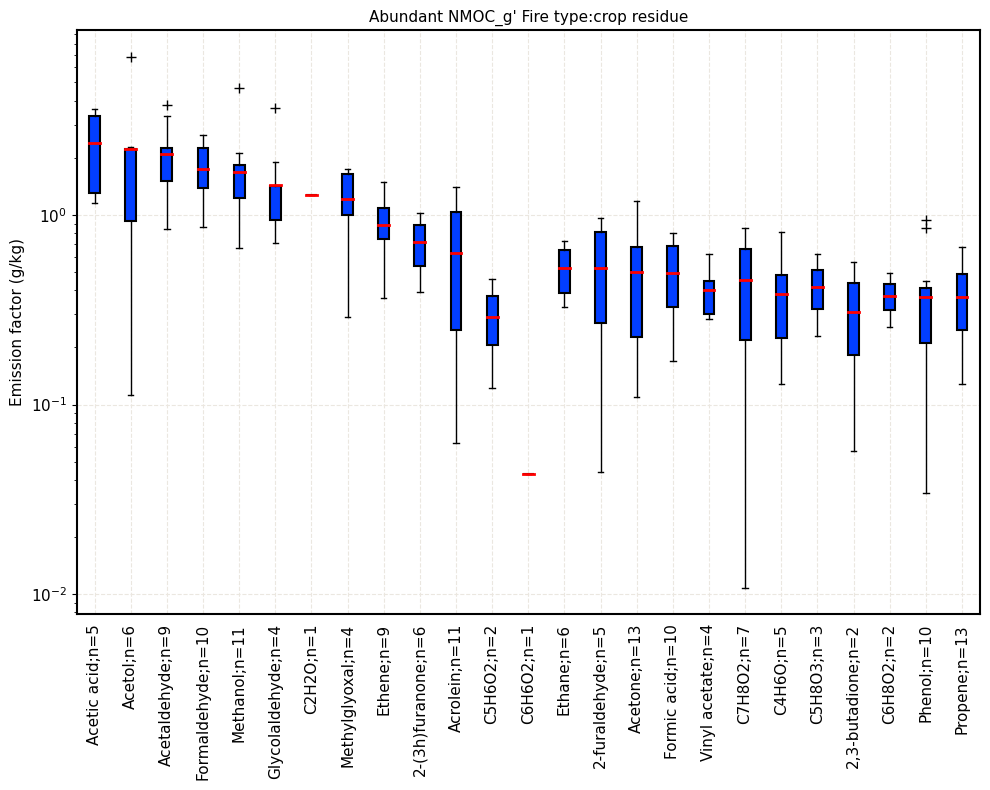

In [46]:
nv.boxplot_abundant_nmog('crop residue')

`nv.nmog_with_high_n(fire type, chem, property)` Retunrs the 25 NMOC_g sorted by data count in ascending order. It also displays the mapped model surrogate and property.
*   Options for fire type: Can be obtained from `nv.fire_type()`.
*   Options for chem(chemical mechanism) and property: Can be obtained from `nv.property_varaible()`.

In [47]:
nv.nmog_with_high_n('cookstove', 'S07', 'kOH')

,mm,formula,compound,AVG_cookstove,N_cookstove,S07,kOH,id
0,26,C2H2,Acetylene,0.64,14,ACYE,8e-13,InChI=1S/C2H2/c1-2/h1-2H
1,42,C3H6,Propene,0.25,13,OLE1,3e-11,"InChI=1S/C3H6/c1-3-2/h3H,1H2,2H3"
2,28,C2H4,Ethene,1.2,13,ETHE,8e-12,InChI=1S/C2H4/c1-2/h1-2H2
3,54,C4H6,"1,3-butadiene",0.15,13,OLE2,7e-11,"InChI=1S/C4H6/c1-3-4-2/h3-4H,1-2H2"
4,31,CH3O,Methanol,0.98,13,MEOH,9e-13,"InChI=1S/CH4O/c1-2/h2H,1H3"
5,30,CH2O,Formaldehyde,0.78,12,HCHO,8e-12,InChI=1S/CH2O/c1-2/h1H2
6,46,CH2O2,Formic acid,0.13,11,FACD,5e-13,"InChI=1S/CH2O2/c2-1-3/h1H,(H,2,3)"
7,68,C5H8,Isoprene,0.04,10,ISOP,1e-10,"InChI=1S/C5H8/c1-4-5(2)3/h4H,1-2H2,3H3"
8,60,C2H4O2,Acetic acid,2.12,9,AACD,7e-13,"InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4)"
9,27,HCN,HCN,0.3,9,NROG,3e-14,InChI=1S/CHN/c1-2/h1H


`nv.nmog_with_high_ohr (df, fire type, chem, sum_nmoc_g_ef_ppb)` Returns the 25 NMOC_g sorted by OHR in ascending order. It requires a dataframe in recommended table format as input.
*   Options for fire type: Can be obtained from `nv.fire_type()`.
*   Options for chem(chemical mechanism): Can be obtained from `nv.property_varaible()`.
*   `sum_nmoc_g_ef_ppb`: The summation of NMOC_g EF in ppb unit.

In [48]:
nv.nmog_with_high_ohr (rdf, 'temperate forest', 'S07', 91)

,mm,formula,compound,AVG_temperate_forest,OHR(s-1),kOH(cm3/molecule sec),S07
0,110,C6H6O2,Resorcinol,1.49,9.12,2e-10,CRES
1,42,C2H2O,Ketene fregments,1.35,7.54,7e-11,MVK
2,30,CH2O,Formaldehyde,2.04,1.93,8e-12,HCHO
3,44,C2H4O,Acetaldehyde,1.56,1.78,1e-11,CCHO
4,42,C3H6,Propene,0.69,1.6,3e-11,OLE1
5,136,C10H16,D-limonene,0.37,1.47,2e-10,TERP
6,28,C2H4,Ethene,1.36,1.29,8e-12,ETHE
7,68,C5H8,Isoprene,0.26,1.27,1e-10,ISOP
8,98,C5H6O2,2-furan methanol,0.33,1.16,1e-10,ARO1
9,84,C5H8O,Pentenone,0.95,1.1,3e-11,IPRD


`nv.plot_model_surrogate(df, fire type, chem, model surrogate)` Generates a boxplot illustrating NMOC_g versus EF. The NMOC_g are selected based on the speciifed chemical mechanism and model surrogate. If there are more than 25 NMOC_gs, it plots the first 25 NMOC_g.
*   Options for fire type: Can be obtained from `nv.fire_type()`.
*   Options for chem(chemical mechanism): Can be obtained from `nv.property_varaible()`.
*   Options for model surroagte: Can be obtained from `nv.model_surrogates()`.

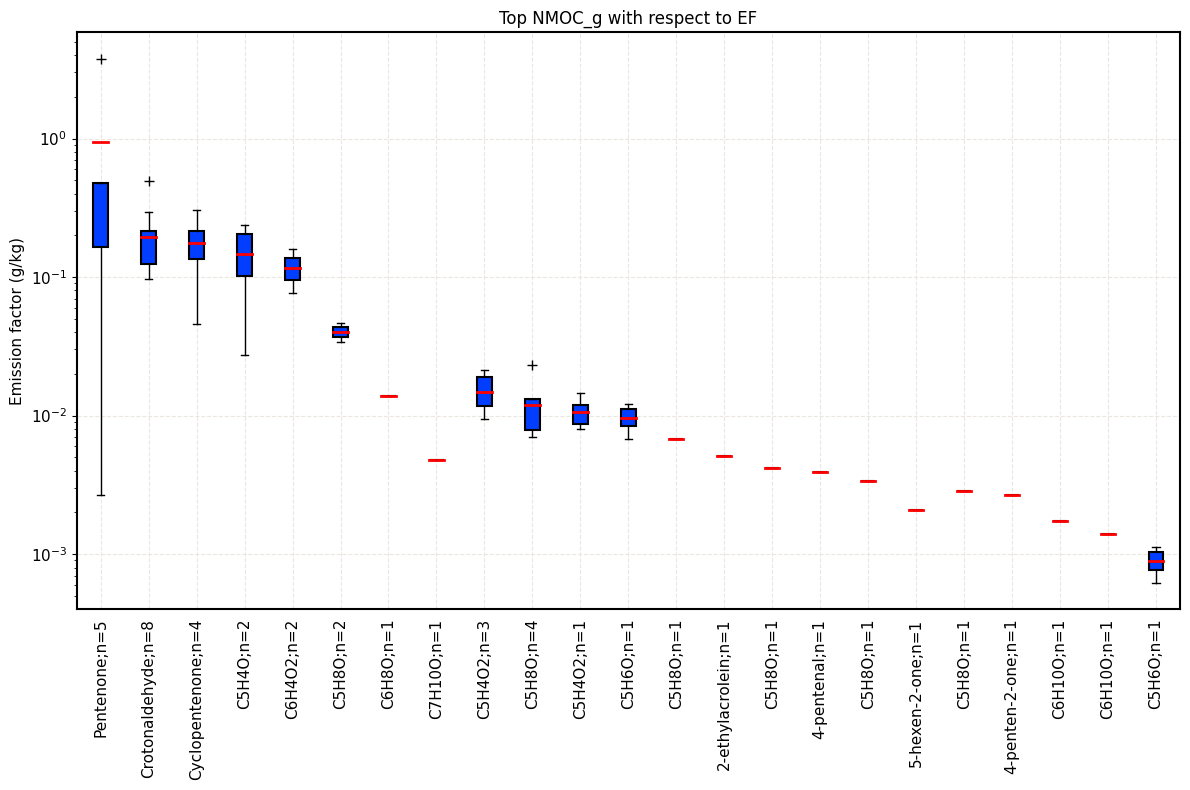

In [49]:
nv.plot_model_surrogate(rdf, 'temperate forest', 'S07','IPRD')